# Fashion and Apparel Classification

**Kaggle Description:**

Designers know what they are creating, but what, and how, do people really wear their products? What combinations of products are people using? In this competition, we challenge you to develop algorithms that will help with an important step towards automatic product detection – to accurately assign segmentations and attribute labels for fashion images.

Visual analysis of clothing is a topic that has received increasing attention in recent years. Being able to recognize apparel products and associated attributes from pictures could enhance the shopping experience for consumers, and increase work efficiency for fashion professionals.

We present a new clothing dataset with the goal of introducing a novel fine-grained segmentation task by joining forces between the fashion and computer vision communities. The proposed task unifies both categorization and segmentation of rich and complete apparel attributes, an important step toward real-world applications.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import cv2
import json
import keras
from PIL import Image
from wordcloud import WordCloud

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
# path = '../input/'

In [5]:
train_df = pd.read_csv('train.csv')
train_df.head()

,ImageId,EncodedPixels,Height,Width,ClassId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32


In [6]:
train_df.shape

(331213, 5)

## Image Size Overview

In [7]:
# image height stats
print("No. of unique heights = {0}".format(train_df.Height.unique().shape[0]))
print("Min height = {0}".format(train_df.Height.min()))
print("Max height = {0}".format(train_df.Height.max()))
print("Mean height = {0}".format(train_df.Height.mean()))

No. of unique heights = 4135
Min height = 296
Max height = 8688
Mean height = 2242.4001020491346


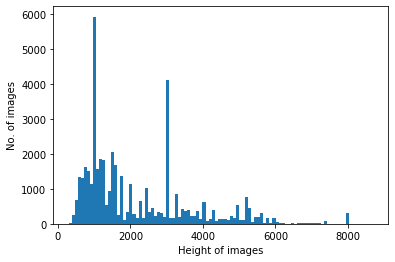

In [8]:
plt.hist(train_df.groupby(["ImageId"]).agg("mean")["Height"],bins=100)
plt.xlabel('Height of images')
plt.ylabel('No. of images')
plt.show()

In [9]:
# image width stats
print("No. of unique widths = {0}".format(train_df.Width.unique().shape[0]))
print("Min width = {0}".format(train_df.Width.min()))
print("Max width = {0}".format(train_df.Width.max()))
print("Mean width = {0}".format(train_df.Width.mean()))

No. of unique widths = 3690
Min width = 257
Max width = 10717
Mean width = 1766.1136972280678


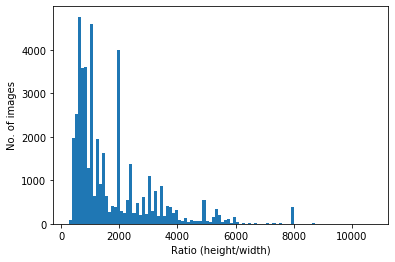

In [10]:
# plot the ratio (height/width)
plt.hist(train_df.groupby(["ImageId"]).agg("mean")["Width"],bins=100)
plt.xlabel('Ratio (height/width)')
plt.ylabel('No. of images')
plt.show()

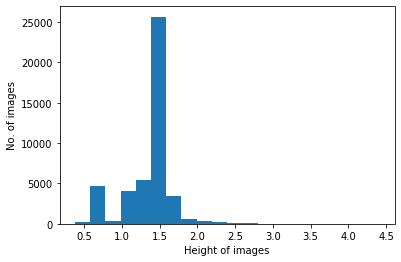

In [11]:
# image size ratio: height/width
plt.hist(train_df.groupby(["ImageId"]).agg("mean")["Height"] / train_df.groupby(['ImageId']).agg("mean")["Width"]
         , bins = 20)
plt.xlabel('Height of images')
plt.ylabel('No. of images')
plt.show()

#### Observations:
- Most images have height > width
- Average height = 2236
- Average width = 1762

We may consider this when resizing the image if we will resize them to the same size.

### Groupby ImageId 

In [12]:
train_df.ImageId.unique().shape[0]

45195

In [13]:
num_classes = train_df.groupby(by=['ImageId']).count()['ClassId'].tolist()
print('Min No. of classes is {0} and Max No. is {1}'.format(min(num_classes), max(num_classes)))

Min No. of classes is 1 and Max No. is 74


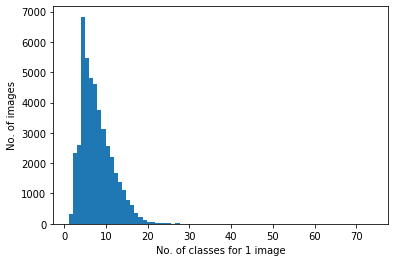

In [14]:
plt.hist(num_classes, bins=74)
plt.xlabel('No. of classes for 1 image')
plt.ylabel('No. of images')
plt.show()

### Groupby ClassId

In [16]:
train_df.ClassId.unique().shape[0]

6354

## Label Description 

In [17]:
label_description = open('label_descriptions.json').read()
label_description = json.loads(label_description)
label_description.keys()

dict_keys(['info', 'categories', 'attributes'])

In [18]:
label_description_info = label_description['info']
label_description_categories = pd.DataFrame(label_description['categories'])
label_description_attributes = pd.DataFrame(label_description['attributes'])

In [19]:
label_description_info

{'year': 2019,
 'version': '1.0',
 'description': 'The 2019 FGVC^6 iMaterialist Competition - Fashion track dataset.',
 'contributor': 'iMaterialist Fashion Competition group',
 'url': 'https://github.com/visipedia/imat_comp',
 'date_created': '2019-04-19 12:38:27.493919'}

In [20]:
label_description_categories

,id,name,supercategory,level
0,0,"shirt, blouse",upperbody,2
1,1,"top, t-shirt, sweatshirt",upperbody,2
2,2,sweater,upperbody,2
3,3,cardigan,upperbody,2
4,4,jacket,upperbody,2
5,5,vest,upperbody,2
6,6,pants,lowerbody,2
7,7,shorts,lowerbody,2
8,8,skirt,lowerbody,2
9,9,coat,wholebody,2


In [21]:
label_description_attributes

,id,name,supercategory,level
0,0,above-the-hip (length),length,1
1,1,hip (length),length,1
2,2,micro (length),length,1
3,3,mini (length),length,1
4,4,above-the-knee (length),length,1
...,...,...,...,...
87,87,high waist,waistline,1
88,88,normal waist,waistline,1
89,89,low waist,waistline,1
90,90,basque (wasitline),waistline,1


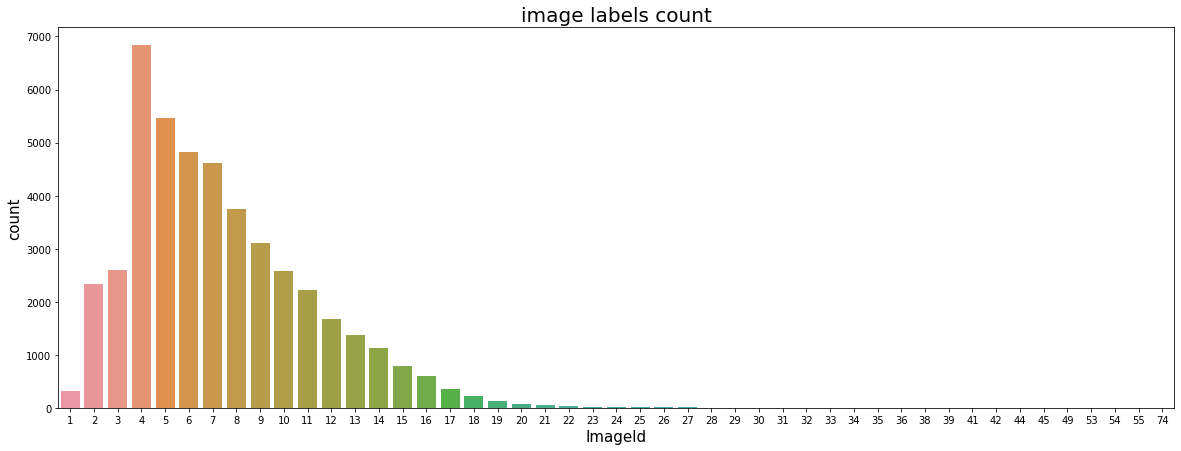

In [22]:
train_df_ImageId_count = train_df['ImageId'].value_counts()
plt.figure(figsize=(20, 7))
plt.title('image labels count', size=20)
plt.xlabel('', size=15); plt.ylabel('', size=15);
sns.countplot(train_df_ImageId_count)
plt.show()

In [23]:
label_description_categories.shape, label_description_attributes.shape

((46, 4), (92, 4))

In [24]:
train_classid = pd.DataFrame({'ClassId':train_df['ClassId'].apply(lambda x: x[:2].replace('_', ''))})
label_merge = label_description_categories[['id', 'name']].astype(str).astype(object)

In [25]:
train_df_name = train_classid.merge(label_merge, left_on='ClassId', right_on='id', how='left')
sum1 = train_df_name.shape[0]
ratio1 = np.round(train_df_name.groupby(['ClassId', 'name']).count().sort_values(by='id', ascending=False).rename(columns = {'id':'count'})/sum1 * 100, 2)

In [26]:
train_df_name_stat = train_df_name.groupby(['ClassId', 'name']).count().sort_values(by='id', ascending=False).rename(columns = {'id':'count'}).reset_index()
train_df_name_stat['ratio(%)'] = ratio1.values
train_df_name_stat

,ClassId,name,count,ratio(%)
0,31,sleeve,58810,17.76
1,23,shoe,46206,13.95
2,33,neckline,33903,10.24
3,32,pocket,27037,8.16
4,10,dress,18665,5.64
5,1,"top, t-shirt, sweatshirt",16230,4.90
6,6,pants,12375,3.74
7,28,collar,10129,3.06
8,35,zipper,7965,2.40
9,4,jacket,7808,2.36


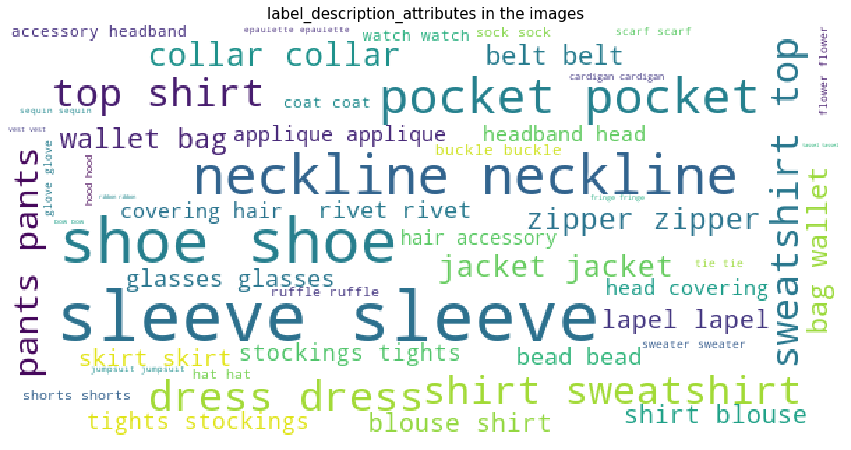

In [27]:
text = ''
for idx, name in enumerate(train_df_name_stat['name']):
    text += (name + ' ') * train_df_name_stat.loc[idx, 'count']
text = text[:-1]

wordcloud = WordCloud(max_font_size=50, width=600, height=300, background_color='white').generate(text)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.title("label_description_attributes in the images", fontsize=15)
plt.axis("off")
plt.show() 

In [28]:
train_classid = pd.DataFrame({'ClassId':[j for i in train_df['ClassId'][train_df['ClassId'].apply(lambda x: '_' in x)].apply(lambda x: x.split('_')[1:]) for j in i]})
label_merge = label_description_attributes[['id', 'name']].astype(str).astype(object)

In [29]:
train_df_name = train_classid.merge(label_merge, left_on='ClassId', right_on='id', how='left')
sum1 = train_df_name.shape[0]
ratio1 = np.round(train_df_name.groupby(['ClassId', 'name']).count().sort_values(by='id', ascending=False).rename(columns = {'id':'count'})/sum1 * 100, 3)

In [30]:
train_df_name_stat = train_df_name.groupby(['ClassId', 'name']).count().sort_values(by='id', ascending=False).rename(columns = {'id':'count'}).reset_index()
train_df_name_stat['ratio(%)'] = ratio1.values
train_df_name_stat

,ClassId,name,count,ratio(%)
0,20,symmetrical,10734,15.020
1,61,plain (pattern),8684,12.151
2,60,no special manufacturing technique,6371,8.915
3,41,regular (fit),3660,5.121
4,88,normal waist,3553,4.972
...,...,...,...,...
87,74,herringbone (pattern),10,0.014
88,76,argyle,9,0.013
89,21,peplum,9,0.013
90,80,peacock,7,0.010


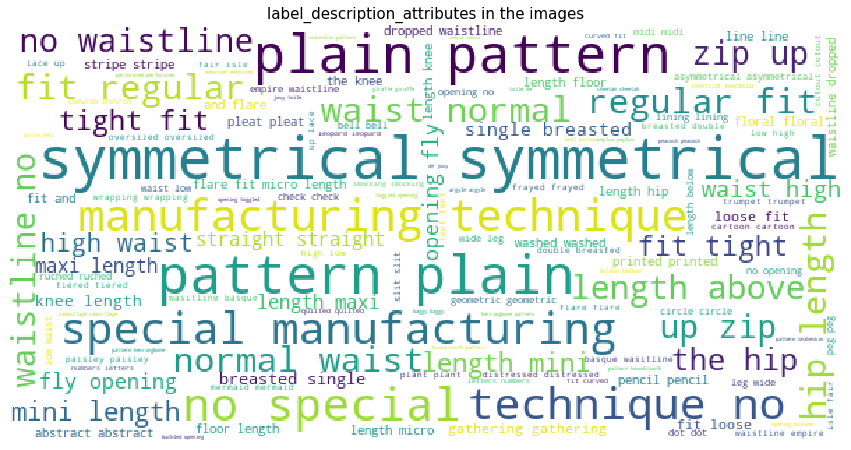

In [34]:
text = ''
for idx, name in enumerate(train_df_name_stat['name']):
    text += (name + ' ') * train_df_name_stat.loc[idx, 'count']
text = text[:-1]

wordcloud = WordCloud(max_font_size=50, width=600, height=300, background_color='white').generate(text)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.title("label_description_attributes in the images", fontsize=15)
plt.axis("off")
plt.show() 

## Supercategory Analysis

Both attributes abd categories contain additional `supercatrgory` column, which may generate insights. Clothes from the same subcategory are similar somehow. Attribute's supercatrgory denotes that it describes some specific property (i.e. length, style).

In [36]:
train_df['hasAttributes'] = train_df.ClassId.apply(lambda x: x.find("_") > 0)
train_df['CategoryId'] = train_df.ClassId.apply(lambda x: x.split("_")[0]).astype(int)
train_df = train_df.merge(label_description_categories, left_on="CategoryId", right_on="id")

In [37]:
print("Fraction of mask annotations with any attributes within train data:", 
      train_df.hasAttributes.mean())

Fraction of mask annotations with any attributes within train data: 0.034717840181393844


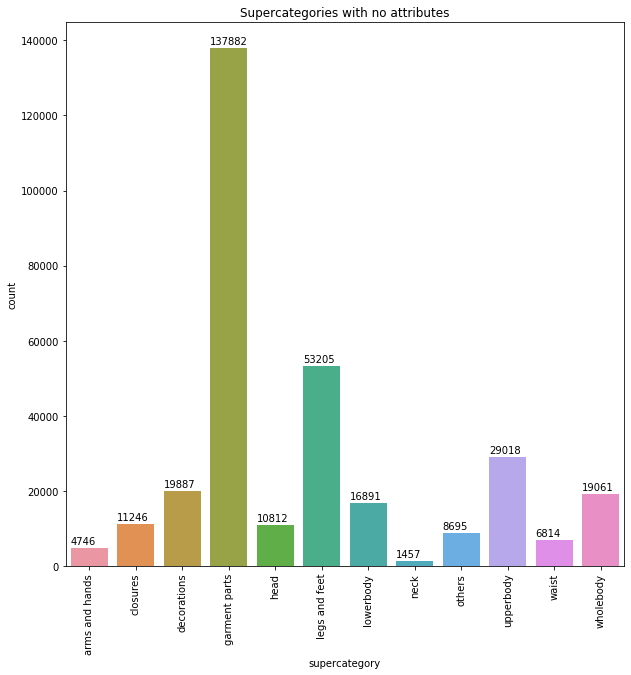

In [49]:
# Supercategories with no attributes
subset = train_df[~ train_df.hasAttributes]
supercategory_names = np.unique(subset.supercategory)
plt.figure(figsize = (10,10))
g = sns.countplot(x = 'supercategory', data=subset, order=supercategory_names)
ax = g.axes
tl = [x.get_text() for x in ax.get_xticklabels()]
plt.setp(ax.get_xticklabels(), rotation=90)
for p, label in zip(ax.patches, supercategory_names):
    c = subset[(subset['supercategory'] == label)].shape[0]
    ax.annotate(str(c), (p.get_x(), p.get_height() + 1000))
plt.title("Supercategories with no attributes")
plt.show()

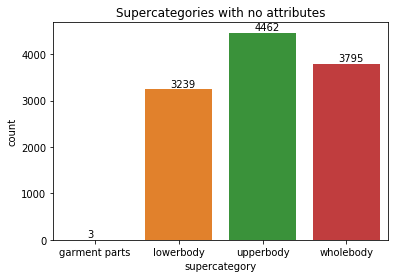

In [50]:
# Supercategories with any attributes
subset = train_df[train_df.hasAttributes]
supercategory_names = np.unique(subset.supercategory)

g = sns.countplot(x = 'supercategory', data=subset, order=supercategory_names)
ax = g.axes
tl = [x.get_text() for x in ax.get_xticklabels()]
plt.setp(ax.get_xticklabels(tl), rotation=90)
for p, label in zip(ax.patches, supercategory_names):
    c = subset[(subset['supercategory'] == label)].shape[0]
    ax.annotate(str(c), (p.get_x()+0.3, p.get_height() + 50))
plt.title("Supercategories with no attributes")
plt.show()

**Observation:** 
- No. of mask annotations with any attribute is small, only masks related to 3-4 supercategories have any associated attribute.
- Other supercategories could be ignored.

### Variance within the supercategories

In [52]:
supercategory_names = train_df[['supercategory','name']].groupby('supercategory').agg(lambda x: x.unique().shape[0]).reset_index().sort_values('name', ascending=False).set_index('name')
supercategory_names

,supercategory
name,
10,decorations
7,garment parts
6,upperbody
4,legs and feet
4,wholebody
3,head
3,lowerbody
3,others
2,arms and hands


#### Compare counts for supercategories

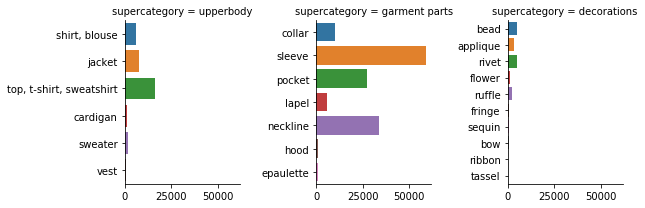

In [53]:
# supercategory: decorations, garment parts, upperbody
def buildPlot(**kwargs):
    data = kwargs['data']
    g = sns.countplot(y = 'name', data = data)
    g.set_yticklabels(data['name'].unique())
    
idx = train_df.supercategory.isin(['decorations','garment parts','upperbody'])
g = sns.FacetGrid(data=train_df[idx], col='supercategory', sharey=False)
g = g.map_dataframe(buildPlot)

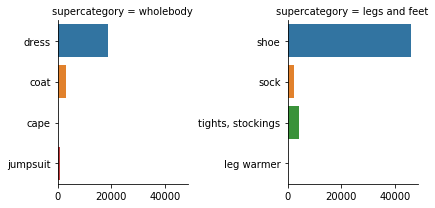

In [54]:
# supercategory: wholebody, legs and feet
idx = train_df.supercategory.isin(supercategory_names.supercategory.loc[4].values)
g = sns.FacetGrid(data=train_df[idx], col='supercategory', sharey=False)
g = g.map_dataframe(buildPlot)

The most common `wholebody` cloth type is `dress`. `Shoe` dominates in the `legs and feet` supercategory, which means it may be worthwile to search for shoes on the images.

In [56]:
total = train_df.ImageId.unique().shape[0]
print(f'There are {total} images in train dataset')

images_with_shoes = train_df[train_df.name == 'shoe'].ImageId.unique().shape[0]
images_with_legs = train_df[train_df.supercategory == 'legs and feet'].ImageId.unique().shape[0]

print(f'However, only {images_with_legs} images have associated legs and feet annotation, and only {images_with_shoes} have shoes on it')    

There are 45195 images in train dataset
However, only 24377 images have associated legs and feet annotation, and only 23870 have shoes on it


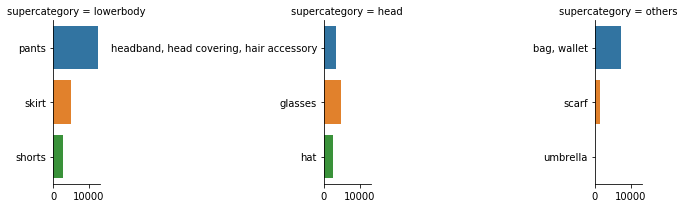

In [57]:
# supercategory: lowerbody, head, others
idx = train_df.supercategory.isin(supercategory_names.supercategory.loc[3].values)
g = sns.FacetGrid(data=train_df[idx], col='supercategory', sharey=False)
g = g.map_dataframe(buildPlot)

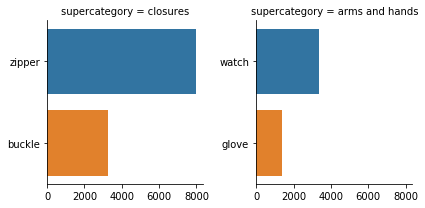

In [58]:
# supercategory: closures, arms and hands
idx = train_df.supercategory.isin(supercategory_names.supercategory.loc[2].values)
g = sns.FacetGrid(data=train_df[idx], col='supercategory', sharey=False)
g = g.map_dataframe(buildPlot)

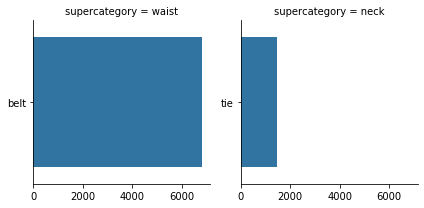

In [59]:
# supercategory: waist, neck
idx = train_df.supercategory.isin(supercategory_names.supercategory.loc[1].values)
g = sns.FacetGrid(data=train_df[idx], col='supercategory', sharey=False)
g = g.map_dataframe(buildPlot)

# More Exploration of Image Data

In [60]:
import os
path = '../input/'

In [61]:
sub = pd.read_csv('sample_submission.csv')

In [62]:
print('The number of training image is {}.'.format(len(os.listdir('train'))))
print('train data unique length is {}.\n'.format(len(np.unique(train_df['ImageId']))))
print('The number of test image is {}.'.format(len(os.listdir('test'))))
print('test data unique length is {}.'.format(len(np.unique(sub['ImageId']))))

The number of training image is 45196.
train data unique length is 45195.

The number of test image is 3193.
test data unique length is 3200.


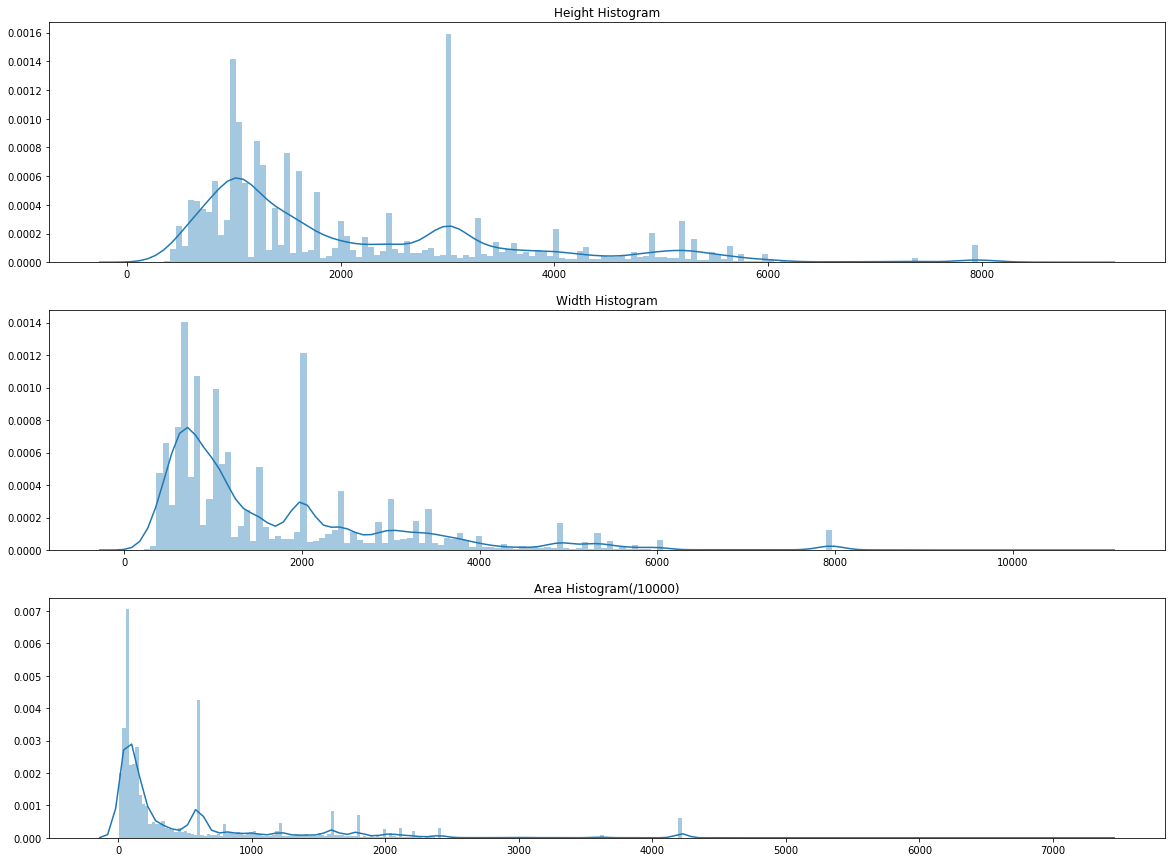

In [22]:
f, axes = plt.subplots(3, 1, figsize=(20, 15))
plt.subplot(3, 1, 1)
sns.distplot(train_df.groupby('ImageId').mean().reset_index()['Height'].tolist(), bins=150).set_title('Height Histogram')

plt.subplot(3, 1, 2)
sns.distplot(train_df.groupby('ImageId').mean().reset_index()['Width'].tolist(), bins=150).set_title('Width Histogram')

plt.subplot(3, 1, 3)
sns.distplot(train_df.groupby('ImageId').mean().reset_index()['Height'] * train_df.groupby('ImageId').mean().reset_index()['Width']/10000, bins=300).set_title('Area Histogram(/10000)')

plt.show()

## Glance of min and max size image sample

In [95]:
# min height image
image_shape_df = train_df.groupby("ImageId")["Height", "Width"].first()
img_name = image_shape_df.Height.idxmin()
height, width = image_shape_df.loc[img_name, :]
print("Minimam height image is {},\n(H, W) = ({}, {})".format(img_name, height, width))

Minimam height image is 671cb261d0f1e522c1af51e2630b8631.jpg,
(H, W) = (296, 331)


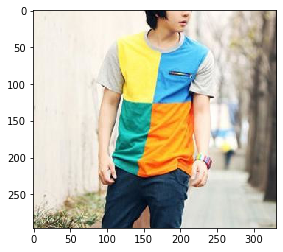

In [98]:
# display min height image
image = Image.open('train/'+'671cb261d0f1e522c1af51e2630b8631.jpg')
plt.figure()
plt.imshow(image) 
plt.show()

In [99]:
# max height image
img_name = image_shape_df.Height.idxmax()
height, width = image_shape_df.loc[img_name, :]
print("Maximum height image is {},\n(H, W) = ({}, {})".format(img_name, height, width))

Maximum height image is 057929711659b06bfdfa48150c2c5231.jpg,
(H, W) = (8688, 5792)


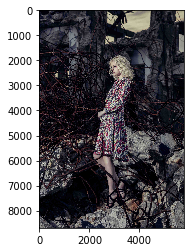

In [100]:
# display max height image
image = Image.open('train/'+'057929711659b06bfdfa48150c2c5231.jpg')
plt.figure()
plt.imshow(image) 
plt.show()

In [104]:
# min width image
img_name = image_shape_df.Width.idxmin()
height, width = image_shape_df.loc[img_name, :]
print("Minimam width image is {},\n(H, W) = ({}, {})".format(img_name, height, width))

Minimam width image is 3bf6fdb03038610e1e6fb4d24dda913f.jpg,
(H, W) = (636, 257)


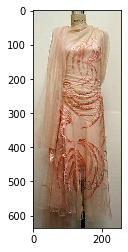

In [103]:
# display min width image
image = Image.open('train/'+'3bf6fdb03038610e1e6fb4d24dda913f.jpg')
plt.figure()
plt.imshow(image) 
plt.show()

In [105]:
# max width image
img_name = image_shape_df.Width.idxmax()
height, width = image_shape_df.loc[img_name, :]
print("Maximum width image is {},\n(H, W) = ({}, {})".format(img_name, height, width))

Maximum width image is 7ccae737f64205acf152c4d66437b4ba.jpg,
(H, W) = (6824, 10717)


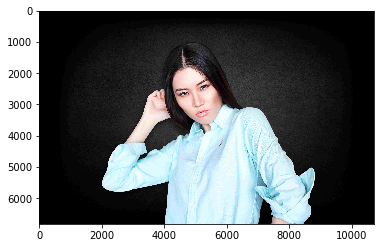

In [106]:
# display max width image
image = Image.open('train/'+'7ccae737f64205acf152c4d66437b4ba.jpg')
plt.figure()
plt.imshow(image) 
plt.show()